In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma
import scipy
from scipy.special import gammaln

%matplotlib inline

mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = (15, 5)

## Compare two Poisson models with different priors

In [14]:
N = 100  # size of toy data

# generate data 
true_lam = 0.5
X_o = np.random.poisson(lam=true_lam, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))


# set prior parameters 
shapes = [0.5, 7.5]
scales = [1.0, 1.0]

## Define functions for generating data from the two different models

In [3]:
def generate_poisson(N, shape, scale): 
    
    # sample from prior
    theta = np.random.gamma(shape=shape, scale=scale)
    # generate samples
    x = np.random.poisson(lam=theta, size=N)
    
    return theta, x

def calculate_stats(x): 
     return np.sum(x).astype(float)
    
def generate_dataset(n_samples, sample_size): 
    
    X = []
    thetas = []
    m = []

    # for every sample we want a triplet (m_i, theta, sx)
    for i in range(n_samples): 
        
        # sample model index 
        m_i = np.round(np.random.rand()).astype(int)
    
        # generate data from model 
        # m_i in {0, 1} just sets the index in the array of prior hyperparams
        shape = shapes[m_i]
        scale = scales[m_i]
        theta, x = generate_poisson(sample_size, shape, scale)
        sx = calculate_stats(x)
    
        X.append([sx])
        thetas.append([theta])
        m.append([int(m_i)])
    
    return m, np.array(thetas), np.array(X)

def normalize(X, norm=None):
    if norm is None: 
        xmean = X.mean(axis=0)
        xstd = X.std(axis=0)
    else: 
        xmean = norm[0]
        xstd = norm[1]
    return (X - xmean) / xstd, (xmean, xstd)

## Define separate networks for fitting the prior parameter posterior and the model posterior

In [4]:
def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.tanh = nn.Tanh()
        self.scale_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())
        self.shape_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_shape = self.scale_out(act)
        out_scale = self.shape_out(act)
        return (out_shape, out_scale)
    
    
def train(X, Y, model, optim, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_shape, out_scale) = model(x_var)
            loss = mdn_loss_function(out_shape, out_scale, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim

## Define posterior model and corresponding loss function for learning theta

In [5]:
# magical gammaln fun from pyro 
def log_gamma(xx):
    gamma_coeff = [
        76.18009172947146,
        -86.50532032941677,
        24.01409824083091,
        -1.231739572450155,
        0.1208650973866179e-2,
        -0.5395239384953e-5,
    ]
    magic1 = 1.000000000190015
    magic2 = 2.5066282746310005
    x = xx - 1.0
    t = x + 5.5
    t = t - (x + 0.5) * torch.log(t)
    ser = Variable(torch.ones(x.size()) * magic1)
    for c in gamma_coeff:
        x = x + 1.0
        ser = ser + torch.pow(x / c, -1)
    return torch.log(ser * magic2) - t


def gamma_pdf(x, shape, scale, log=False): 
    alpha = shape
    beta = 1. / scale
    
    ll_1 = -beta * x
    ll_2 = (alpha - 1.0) * torch.log(x)
    ll_3 = alpha * torch.log(beta)
    ll_4 = -log_gamma(alpha)
    result = torch.sum(ll_1 + ll_2 + ll_3 + ll_4, -1)
    if log:
        return result
    else: 
        return torch.exp(result)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(out_shape, out_scale, y):
    result = gamma_pdf(y, out_shape, out_scale, log=True)
    result = torch.mean(result)  # mean over batch
    return -result

## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [6]:
# generate data 
m, theta, X= generate_dataset(2000, N)
X, norm = normalize(X)

In [7]:
# separate it 
mask = np.array(m).squeeze()
theta1, X1, = theta[mask==0], X[mask==0, :]
theta2, X2, = theta[mask==1], X[mask==1, :]

## Train the phi networks for estimating the posteriors over $\mu$

In [8]:
# now train the networks for the two models 
model1 = MDN_phi()
optim1 = torch.optim.Adam(model1.parameters(), lr=0.01)
model1, optim1 = train(X1, theta1, model=model1, optim=optim1, n_epochs=200)

[epoch 0050] loss: -1.2138
[epoch 0100] loss: -1.4076
[epoch 0150] loss: -1.4925
[epoch 0200] loss: -1.6096


In [9]:
model2 = MDN_phi()
optim2 = torch.optim.Adam(model2.parameters(), lr=0.01)
model2, optim2 = train(X2, theta2, model=model2, optim=optim2, n_epochs=200)

[epoch 0050] loss: 1.7433
[epoch 0100] loss: 1.2195
[epoch 0150] loss: 1.1558
[epoch 0200] loss: 0.9883


In [10]:
def get_posterior(model, X_o, thetas, norm): 
    data = calculate_stats(X_o) 
    data, norm = normalize(data, norm)
    
    stats_o = np.array(data.astype(float)).reshape(1, 1)

    X_var = Variable(torch.Tensor(stats_o))

    # predict shape and scale for given sufficient stats
    (out_shape, out_scale) = model(X_var)

    # evaluate gamma pdf with learned shape and scale parameters
    post = gamma.pdf(x=thetas, a=out_shape.data.numpy(), scale=out_scale.data.numpy())

    return post

In [15]:
thetas = np.linspace(0, 10, 1000)
post1 = get_posterior(model1, X_o, thetas, norm)
post2 = get_posterior(model2, X_o, thetas, norm)

In [16]:
prior1 = gamma.pdf(x=thetas, a=shapes[0], scale=scales[0])
prior2 = gamma.pdf(x=thetas, a=shapes[1], scale=scales[1])

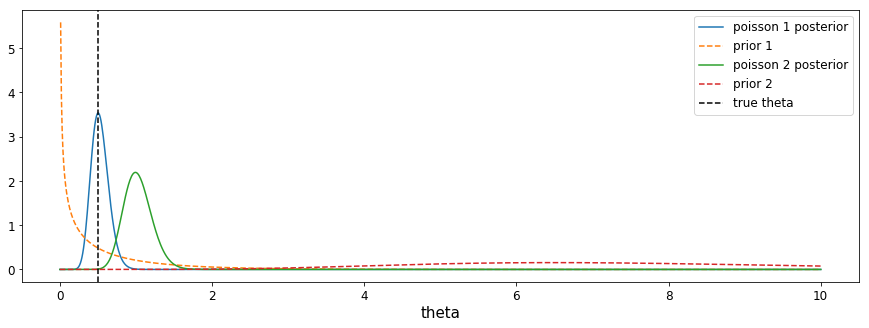

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(thetas, post1.squeeze(), label='poisson 1 posterior')
plt.plot(thetas, prior1, '--', label='prior 1')

plt.plot(thetas, post2.squeeze(), label='poisson 2 posterior')
plt.plot(thetas, prior2, '--', label='prior 2')

plt.axvline(x=true_lam, label='true theta', linestyle='--', color='k')
plt.xlabel('theta')
plt.legend();

## Now train the model posterior

In [18]:
class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=1, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = nn.Linear(n_hidden, ndim_output)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m

def train_psi(X, Y, model, optim, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]
    
    losses = []

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))            
            y_var = Variable(torch.LongTensor(y_batch)).view(n_minibatch)
            
            (out_act) = model(x_var)
            loss = lossfun(out_act, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data[0])

        if (epoch + 1) % 100 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim, losses

In [19]:
model = MDN_psi(n_hidden=10)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
lossfun = nn.CrossEntropyLoss()

model_psi, optim_psi, losses = train_psi(X, m, model, optim, n_epochs=500, n_minibatch=100)

[epoch 0100] loss: 0.3783
[epoch 0200] loss: 0.1409
[epoch 0300] loss: 0.0961
[epoch 0400] loss: 0.0347
[epoch 0500] loss: 0.0615


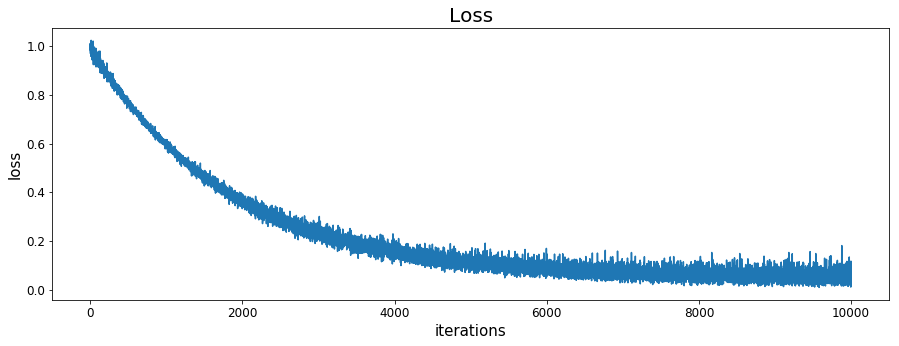

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss');

## Draw many samples and compare predicted to analytical Bayes Factor

In [21]:
def poisson_evidence(x, shape, scale, N, log=False): 
    a = shape 
    b = 1. / scale
    
    x_sum = np.sum(x)
    log_xfac = np.sum(gammaln(x + 1))
    
    result = a * np.log(b) - gammaln(a) - log_xfac + gammaln(a + x_sum) - (a + x_sum)*np.log(b + N)
    
    return result if log else np.exp(result)

In [22]:
bf_true = []
bf_predicted = []
model_indices = []
mi_pred = []

# gather summary stats
stats = []

softmax = nn.Softmax()

for i in range(100): 
    
    # sample model index 
    m_i = np.round(np.random.rand()).astype(int)
    
    # draw samples from the model given by the model index 
    if m_i == 0: 
        samples = np.random.poisson(0.5, N)
    elif m_i == 1: 
        samples = np.random.poisson(6.0, N)
    
    # apply model for prediction
    stats_o = calculate_stats(samples).reshape(1, 1)
    stats_o, norm = normalize(stats_o, norm)
    
    stats.append(stats_o)
    
    X_var = Variable(torch.Tensor(stats_o))
    (out_act) = model(X_var)
    
    # in this vector, index 0 is Poi, index 1 is NB
    posterior_probs = softmax(out_act).data.numpy()[0]
    # predict the model with the larger posterior 
    mi_pred.append(np.argmax(posterior_probs))
    
    # because we use a uniform prior the posterior ratio corresponds to the likelihood (evidence) ratio
    e0 = poisson_evidence(samples, shapes[0], scales[0], N, log=True)
    e1 = poisson_evidence(samples, shapes[1], scales[1], N, log=True)

    # calculate bf
    log_bftrue = e0 - e1
    log_bfpred = np.log(posterior_probs[0]) - np.log(posterior_probs[1])
    
    # append to lists
    bf_predicted.append(log_bfpred)
    bf_true.append(log_bftrue)
    model_indices.append(m_i)
    
mi_true = np.array(model_indices)
mi_pred = np.array(mi_pred)
# we predict m0 if logbf > 0 
mi_ana = (np.array(bf_true) < 0.)
stats = np.array(stats).squeeze()

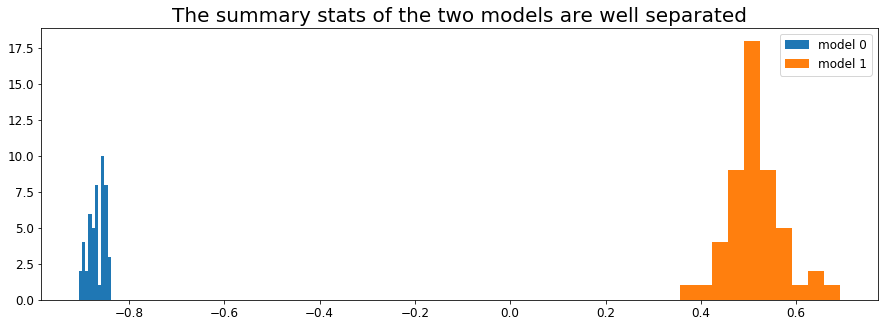

In [23]:
plt.title('The summary stats of the two models are well separated')
plt.hist(stats[mi_true==0], label='model 0')
plt.hist(stats[mi_true==1], label='model 1')
plt.legend(); 

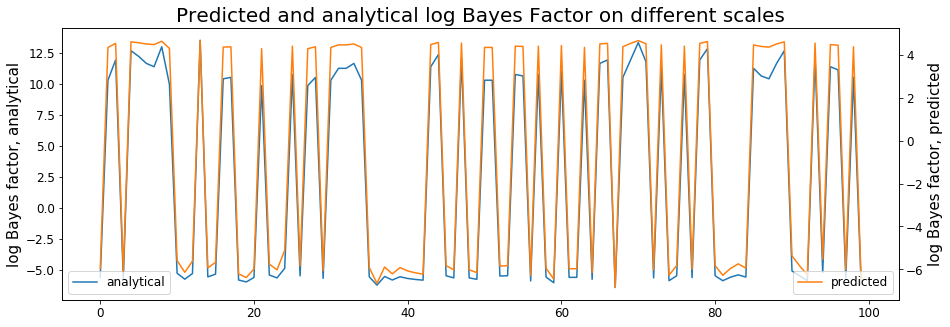

In [24]:
plt.plot(bf_true, label='analytical', color='C0')
plt.ylabel('log Bayes factor, analytical')
plt.legend(loc=3)

plt.twinx()
plt.plot(bf_predicted, label='predicted', color='C1')
plt.ylabel('log Bayes factor, predicted')
plt.xlabel('different data sets')
plt.legend(loc=4)
plt.title('Predicted and analytical log Bayes Factor on different scales');

In [25]:
np.corrcoef(bf_true, bf_predicted)

array([[ 1.        ,  0.99786236],
       [ 0.99786236,  1.        ]])

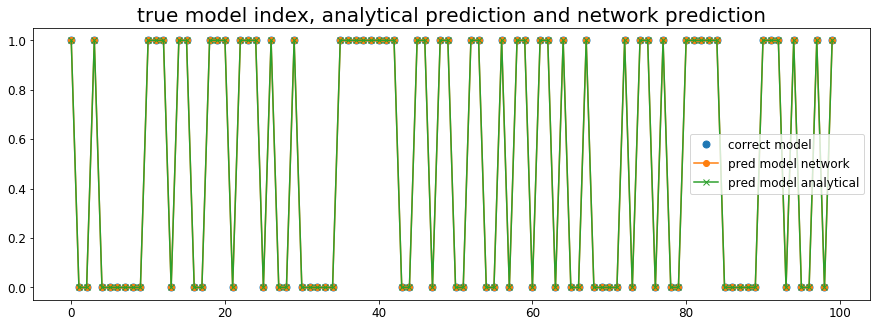

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(mi_true, 'o', label='correct model', alpha=1., markersize=7, lw=3)
plt.plot(mi_pred, 'o-', label='pred model network')
plt.plot(mi_ana, 'x-', label='pred model analytical', alpha=1.)
plt.legend()
plt.title('true model index, analytical prediction and network prediction');